<a href="https://colab.research.google.com/github/yoyoyo-yo/DeepLearningMugenKnock/blob/master/pytorch/EfficientNet_CIFAR100_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EfficientNet, CIFAR100

EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks https://arxiv.org/abs/1905.11946 (2019)

In [20]:
!pip install numpy matplotlib opencv-python torch torchvision torchsummary pandas easydict

## Import and Config

In [28]:
import os
from pprint import pprint
import argparse

import numpy as np
from collections import OrderedDict
from easydict import EasyDict
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import seaborn as sns

import torch
import torch.nn.functional as F
import torchvision
from torchsummary import summary

#---
# config
#---
cfg = EasyDict()

# class
cfg.CLASS_LABEL = range(100) # list, dict('label' : '[B, G, R]')
cfg.CLASS_NUM = len(cfg.CLASS_LABEL)

# model
cfg.INPUT_HEIGHT = 32
cfg.INPUT_WIDTH = 32
cfg.INPUT_CHANNEL = 3
cfg.INPUT_MODE = 'RGB' #RGB, GRAY, CLASS_LABEL, EDGE

cfg.CHANNEL_AXIS = 1 # 1 ... [mb, c, h, w], 3 ... [mb, h, w, c]

cfg.GPU = True
cfg.DEVICE_TYPE = 'cuda' if cfg.GPU and torch.cuda.is_available() else 'cpu'
cfg.DEVICE = torch.device(cfg.DEVICE_TYPE)


# train
cfg.TRAIN = EasyDict()
cfg.TRAIN.DISPAY_ITERATION_INTERVAL = 50

cfg.PREFIX = 'EfficientNet_CIFAR100'
cfg.TRAIN.MODEL_SAVE_PATH = 'models/' + cfg.PREFIX + '_{}.pt'
cfg.TRAIN.MODEL_SAVE_INTERVAL = 200
cfg.TRAIN.ITERATION = 5_000
#cfg.TRAIN.EPOCH = 2
cfg.TRAIN.MINIBATCH = 256
cfg.TRAIN.OPTIMIZER = torch.optim.SGD
cfg.TRAIN.LEARNING_PARAMS = {'lr' : 0.1, 'momentum' : 0.9, 'weight_decay' : 1e-4}
cfg.TRAIN.LOSS_FUNCTION = loss_fn = torch.nn.NLLLoss()

cfg.TRAIN.DATA_PATH = './data/' # 'drive/My Drive/Colab Notebooks/Dataset/train/images/'
cfg.TRAIN.DATA_HORIZONTAL_FLIP = False
cfg.TRAIN.DATA_VERTICAL_FLIP = False
cfg.TRAIN.DATA_ROTATION = False

cfg.TRAIN.LEARNING_PROCESS_RESULT_SAVE = True
cfg.TRAIN.LEARNING_PROCESS_RESULT_INTERVAL = 500
cfg.TRAIN.LEARNING_PROCESS_RESULT_IMAGE_PATH = 'result/' + cfg.PREFIX + '_result_{}.jpg'
cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH = 'result/' + cfg.PREFIX + '_loss.csv'

# test
cfg.TEST = EasyDict()
cfg.TEST.MODEL_PATH = cfg.TRAIN.MODEL_SAVE_PATH.format('final')
cfg.TEST.DATA_PATH = './data/' # 'drive/My Drive/Colab Notebooks/Dataset/test/images/
cfg.TEST.MINIBATCH = 100
cfg.TEST.ITERATION = 2
cfg.TEST.MAX_NUM = 100
cfg.TEST.RESULT_SAVE = False
cfg.TEST.RESULT_IMAGE_PATH = 'result/' + cfg.PREFIX + '_result_{}.jpg'

# random seed
torch.manual_seed(0)


# make model save directory
def make_dir(path):
    if '/' in path:
        model_save_dir = '/'.join(path.split('/')[:-1])
        os.makedirs(model_save_dir, exist_ok=True)

make_dir(cfg.TRAIN.MODEL_SAVE_PATH)
make_dir(cfg.TRAIN.LEARNING_PROCESS_RESULT_IMAGE_PATH)
make_dir(cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH)
    
pprint(cfg)

{'CHANNEL_AXIS': 1,
 'CLASS_LABEL': range(0, 100),
 'CLASS_NUM': 100,
 'DEVICE': device(type='cuda'),
 'DEVICE_TYPE': 'cuda',
 'GPU': True,
 'INPUT_CHANNEL': 3,
 'INPUT_HEIGHT': 32,
 'INPUT_MODE': 'RGB',
 'INPUT_WIDTH': 32,
 'PREFIX': 'EfficientNet_CIFAR100',
 'TEST': {'DATA_PATH': './data/',
          'ITERATION': 2,
          'MAX_NUM': 100,
          'MINIBATCH': 100,
          'MODEL_PATH': 'models/EfficientNet_CIFAR100_final.pt',
          'RESULT_IMAGE_PATH': 'result/EfficientNet_CIFAR100_result_{}.jpg',
          'RESULT_SAVE': False},
 'TRAIN': {'DATA_HORIZONTAL_FLIP': False,
           'DATA_PATH': './data/',
           'DATA_ROTATION': False,
           'DATA_VERTICAL_FLIP': False,
           'DISPAY_ITERATION_INTERVAL': 50,
           'ITERATION': 5000,
           'LEARNING_PARAMS': {'lr': 0.1,
                               'momentum': 0.9,
                               'weight_decay': 0.0001},
           'LEARNING_PROCESS_RESULT_IMAGE_PATH': 'result/EfficientNet_CIFAR100_

## Define Model

In [0]:
class EfficientNet(torch.nn.Module):
    def __init__(self, block_type='B0'):
        super(EfficientNet, self).__init__()

        print('--')
        print('You call EfficientNet')
        print(' - Input dim (h, w, c) >> ({}, {}, {})'.format(cfg.INPUT_HEIGHT, cfg.INPUT_WIDTH, cfg.INPUT_CHANNEL))
        print('--')

        EFFICIENTNET_CONFIG = {
            'B0' : {'WIDTH_COEFFICIENT' : 1, 'DEPTH_COEFFICIENT' : 1, 'DROPOUT_RATIO' : 0.2, 'DEPTH_DIVISOR' : 8, 'DROP_CONNECT_RATIO' : 0.2},
            'B1' : {'WIDTH_COEFFICIENT' : 1, 'DEPTH_COEFFICIENT' : 1.1, 'DROPOUT_RATIO' : 0.2, 'DEPTH_DIVISOR' : 8, 'DROP_CONNECT_RATIO' : 0.2},
            'B2' : {'WIDTH_COEFFICIENT' : 1.1, 'DEPTH_COEFFICIENT' : 1.2, 'DROPOUT_RATIO' : 0.3, 'DEPTH_DIVISOR' : 8, 'DROP_CONNECT_RATIO' : 0.2},
            'B3' : {'WIDTH_COEFFICIENT' : 1.2, 'DEPTH_COEFFICIENT' : 1.4, 'DROPOUT_RATIO' : 0.3, 'DEPTH_DIVISOR' : 8, 'DROP_CONNECT_RATIO' : 0.2},
            'B4' : {'WIDTH_COEFFICIENT' : 1.2, 'DEPTH_COEFFICIENT' : 1.4, 'DROPOUT_RATIO' : 0.3, 'DEPTH_DIVISOR' : 8, 'DROP_CONNECT_RATIO' : 0.2},
            'B5' : {'WIDTH_COEFFICIENT' : 1.6, 'DEPTH_COEFFICIENT' : 2.2, 'DROPOUT_RATIO' : 0.4, 'DEPTH_DIVISOR' : 8, 'DROP_CONNECT_RATIO' : 0.2},
            'B6' : {'WIDTH_COEFFICIENT' : 1.8, 'DEPTH_COEFFICIENT' : 2.6, 'DROPOUT_RATIO' : 0.5, 'DEPTH_DIVISOR' : 8, 'DROP_CONNECT_RATIO' : 0.2},
            'B7' : {'WIDTH_COEFFICIENT' : 2.0, 'DEPTH_COEFFICIENT' : 3.1, 'DROPOUT_RATIO' : 0.5, 'DEPTH_DIVISOR' : 8, 'DROP_CONNECT_RATIO' : 0.2}
        }

        width_coefficient = EFFICIENTNET_CONFIG[block_type]['WIDTH_COEFFICIENT']
        depth_coefficient = EFFICIENTNET_CONFIG[block_type]['DEPTH_COEFFICIENT']
        dropout_ratio = EFFICIENTNET_CONFIG[block_type]['DROPOUT_RATIO']
        depth_divisor = EFFICIENTNET_CONFIG[block_type]['DEPTH_DIVISOR']
        drop_connect_rate = EFFICIENTNET_CONFIG[block_type]['DROP_CONNECT_RATIO']

        DEFAULT_BLOCKS_ARGS = [
            # block 1
            {'kernel_size': 3, 'repeats': 1, 'filters_in': 32, 'filters_out': 16,
            'expand_ratio': 1, 'id_skip': True, 'stride': 1, 'se_ratio': 0.25},
            # block 2
            {'kernel_size': 3, 'repeats': 2, 'filters_in': 16, 'filters_out': 24,
            'expand_ratio': 6, 'id_skip': True, 'stride': 2, 'se_ratio': 0.25},
            # block 3
            {'kernel_size': 5, 'repeats': 2, 'filters_in': 24, 'filters_out': 40,
            'expand_ratio': 6, 'id_skip': True, 'stride': 2, 'se_ratio': 0.25},
            # block 4
            {'kernel_size': 3, 'repeats': 3, 'filters_in': 40, 'filters_out': 80,
            'expand_ratio': 6, 'id_skip': True, 'stride': 2, 'se_ratio': 0.25},
            # block 5
            {'kernel_size': 5, 'repeats': 3, 'filters_in': 80, 'filters_out': 112,
            'expand_ratio': 6, 'id_skip': True, 'stride': 1, 'se_ratio': 0.25},
            # block 6
            {'kernel_size': 5, 'repeats': 4, 'filters_in': 112, 'filters_out': 192,
            'expand_ratio': 6, 'id_skip': True, 'stride': 2, 'se_ratio': 0.25},
            # block 7
            {'kernel_size': 3, 'repeats': 1, 'filters_in': 192, 'filters_out': 320,
            'expand_ratio': 6, 'id_skip': True, 'stride': 1, 'se_ratio': 0.25}
        ]

        def round_filters(filters, divisor=depth_divisor):
            """Round number of filters based on depth multiplier."""
            filters *= width_coefficient
            new_filters = max(divisor, int(filters + divisor / 2) // divisor * divisor)
            # Make sure that round down does not go down by more than 10%.
            if new_filters < 0.9 * filters:
                new_filters += divisor
            return int(new_filters)

        def round_repeats(repeats):
            """Round number of repeats based on depth multiplier."""
            return int(np.ceil(depth_coefficient * repeats))

            
        class Reshape(torch.nn.Module):
            def __init__(self, c, h, w):
                super(Reshape, self).__init__()
                self.c = c
                self.h = h
                self.w = w
            
            def forward(self, x):
                x = x.view(x.size()[0], self.c, self.h, self.w)
                return x

        class Flatten(torch.nn.Module):
            def __init__(self):
                super(Flatten, self).__init__()

            def forward(self, x):
                x = x.view(x.size()[0], -1)
                return x

        class Swish(torch.nn.Module):
            def __init__(self):
                super(Swish, self).__init__()

            def forward(self, x):
                return x * torch.sigmoid(x)
                    

        class Block(torch.nn.Module):
            def __init__(self, activation_fn=Swish(), drop_rate=0., name='',
                filters_in=32, filters_out=16, kernel_size=3, stride=1,
                expand_ratio=1, se_ratio=0., id_skip=True):
                super(Block, self).__init__()

                # Expansion phase
                filters = filters_in * expand_ratio

                if expand_ratio != 1:
                    _modules = OrderedDict()
                    _modules[name + 'expand_conv'] = torch.nn.Conv2d(filters_in, filters, kernel_size=1, padding=0, bias=False)
                    _modules[name + 'expand_bn'] = torch.nn.BatchNorm2d(filters)
                    _modules[name + 'expand_activation'] = activation_fn
                    self.expansion = torch.nn.Sequential(_modules)

                # Depthwise Convolution
                _modules = OrderedDict()

                conv_pad = kernel_size // 2
                
                _modules[name + 'dw_conv'] = torch.nn.Conv2d(filters, filters, kernel_size, stride=stride, padding=conv_pad, bias=False, groups=1)
                _modules[name + 'dw_bn'] = torch.nn.BatchNorm2d(filters)
                _modules[name + 'dw_activation'] = activation_fn
                self.DW_conv = torch.nn.Sequential(_modules)


                # Squeeze and Excitation phase
                if 0 < se_ratio <= 1:
                    filters_se = max(1, int(filters_in * se_ratio))

                    _modules = OrderedDict()
                    _modules[name + 'se_sqeeze'] = torch.nn.AdaptiveMaxPool2d((1, 1))
                    _modules[name + 'se_reshape'] = Reshape(c=filters, h=1, w=1)
                    _modules[name + 'se_reduce_conv'] = torch.nn.Conv2d(filters, filters_se, kernel_size=1, padding=0)
                    _modules[name + 'se_reduce_activation'] = activation_fn
                    _modules[name + 'se_expand_conv'] = torch.nn.Conv2d(filters_se, filters, kernel_size=1, padding=0)
                    _modules[name + 'se_expand_activation'] = torch.nn.Sigmoid()
                    self.SE_phase = torch.nn.Sequential(_modules)
                    

                # Output phase
                _modules = OrderedDict()
                _modules[name + 'project_conv'] = torch.nn.Conv2d(filters, filters_out, kernel_size=1, padding=0, bias=False)
                _modules[name + 'project_bn'] = torch.nn.BatchNorm2d(filters_out)
                self.output_phase = torch.nn.Sequential(_modules)


                # 
                self.last_add = False
                if (id_skip is True and stride == 1 and filters_in == filters_out):
                    if drop_rate > 0:
                        self.output_phase_Dropout = torch.nn.Dropout2d(p=drop_rate)

                    self.last_add = True

                
            def forward(self, input_x):
                # expansion phase
                if hasattr(self, 'expansion'):
                    x = self.expansion(input_x)
                else:
                    x = input_x

                x = self.DW_conv(x)

                # Squeeze and Excitation phase
                if hasattr(self, 'SE_phase'):
                    x_SE_phase = self.SE_phase(x)
                    x = x * x_SE_phase

                # Output phase
                x = self.output_phase(x)

                if hasattr(self, 'output_phase_Dropout'):
                    x = self.output_phase_Dropout(x)

                if self.last_add:
                    x = x + input_x

                return x

        # stem
        _modules = OrderedDict()
        _modules['stem_conv'] = torch.nn.Conv2d(cfg.INPUT_CHANNEL, round_filters(32), kernel_size=3, padding=1, stride=2, bias=False)
        _modules['stem_bn'] = torch.nn.BatchNorm2d(round_filters(32))
        _modules['stem_activation'] = Swish()
        self.stem = torch.nn.Sequential(_modules)
        
        # block
        _modules = []

        b = 0
        block_Num = float(sum(args['repeats'] for args in DEFAULT_BLOCKS_ARGS))

        for (i, args) in enumerate(DEFAULT_BLOCKS_ARGS):
            assert args['repeats'] > 0
            # Update block input and output filters based on depth multiplier.
            args['filters_in'] = round_filters(args['filters_in'])
            args['filters_out'] = round_filters(args['filters_out'])

            for j in range(round_repeats(args.pop('repeats'))):
                # The first block needs to take care of stride and filter size increase.
                if j > 0:
                    args['stride'] = 1
                    args['filters_in'] = args['filters_out']

                _modules.append(
                    Block(activation_fn=Swish(), drop_rate=drop_connect_rate * b / block_Num, name='block{}{}_'.format(i + 1, chr(j + 97)), **args))
                b += 1

        self.block = torch.nn.Sequential(*_modules)


        # top
        _modules = OrderedDict()
        _modules['top_conv'] = torch.nn.Conv2d(DEFAULT_BLOCKS_ARGS[-1]['filters_out'], round_filters(1280), kernel_size=1, padding=0, bias=False)
        _modules['top_bn'] = torch.nn.BatchNorm2d(round_filters(1280))
        _modules['top_activation'] = Swish()
        self.top = torch.nn.Sequential(_modules)

        _modules = OrderedDict()
        _modules['top_class_GAP'] = torch.nn.AdaptiveMaxPool2d((1, 1))
        if dropout_ratio > 0:
            _modules['top_class_dropout'] = torch.nn.Dropout2d(p=dropout_ratio)
        _modules['top_class_flatten'] = Flatten()
        _modules['top_class_linear'] = torch.nn.Linear(round_filters(1280), cfg.CLASS_NUM)
        self.top_class = torch.nn.Sequential(_modules)
        
        
    def forward(self, x):
        # stem
        x = self.stem(x)

        # blocks
        x = self.block(x)

        # top
        x = self.top(x)
        x = self.top_class(x)

        x = F.softmax(x, dim=1)        
        return x

## Utility

In [0]:
class BatchGenerator():
    def __init__(self, data_size, batch_size, shuffle=True):
        self.data_size = data_size
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.mbi = 0 # index for iteration
        self.inds = np.arange(data_size)
        if shuffle:
            np.random.shuffle(self.inds)

    def __call__(self):
        if self.mbi + self.batch_size > self.data_size:
            inds = self.inds[self.mbi:]
            if self.shuffle:
                np.random.shuffle(self.inds)
            else:
                inds = np.hstack((inds, self.inds[ : (self.batch_size - (self.data_size - self.mbi))]))
                mbi = self.batch_size - (self.data_size - self.mbi)
        else:
            inds = self.inds[self.mbi : self.mbi + self.batch_size]
            self.mbi += self.batch_size
        return inds


#---
# preprocess for torchvision.datasets
#---
def preprocess(Xs, cfg, mode, hf=False, vf=False, rot=False):
    xs = []

    for x in Xs:
        # resize
        x = cv2.resize(x, (cfg.INPUT_WIDTH, cfg.INPUT_HEIGHT)).astype(np.float32)
        
        # channel BGR -> Gray
        if mode == 'GRAY':
            x = cv2.cvtColor(x, cv2.COLOR_BGR2GRAY)
            x = np.expand_dims(x, axis=-1)
        elif mode == 'EDGE':
            x = cv2.cvtColor(x, cv2.COLOR_BGR2GRAY)
            x = cv2.Canny(x, 100, 150)
            x = np.expand_dims(x, axis=-1)

        # horizontal flip
        if hf and np.random.rand() < 0.5:
            x = x[:, ::-1]

        # vertical flip
        if vf and np.random.rand() < 0.5:
            x = x[::-1]

        # rotation
        if rot != False:
            rot = np.random.randint(0, 360, 1) // rot * rot

            scale = 1

            _h, _w = x.shape[:2]
            _c = 1
            if len(x.shape) == 3:
                _c = x.shape[2]

            max_side = max(_h, _w)
            tmp = np.zeros((max_side, max_side, _c))
            tx = int((max_side - _w) / 2)
            ty = int((max_side - _h) / 2)
            tmp[ty: ty+_h, tx: tx+_w] = x.copy()
            M = cv2.getRotationMatrix2D((max_side / 2, max_side / 2), rot, scale)
            _x = cv2.warpAffine(tmp, M, (max_side, max_side))
            x = _x[tx:tx+_w, ty:ty+_h]

        if mode == 'CLASS_LABEL':
            _x = x
            x = np.zeros((cfg.OUTPUT_HEIGHT, cfg.OUTPUT_WIDTH, cfg.CLASS_NUM), dtype=np.int)

            for i, (_, vs) in enumerate(cfg.CLASS_LABEL.items()):
                ind = (_x[..., 0] == vs[0]) * (_x[..., 1] == vs[1]) * (_x[..., 2] == vs[2])
                x[..., i][ind] = 1

        else:
            # normalization [0, 255] -> [-1, 1]
            x = x / 127.5 - 1

        xs.append(x)
                
    xs = np.array(xs, dtype=np.float32)
    if cfg.CHANNEL_AXIS == 1:
        if len(xs.shape) == 4:
            xs = xs.transpose(0, 3, 1, 2)
        else:
            xs = np.expand_dims(xs, axis=1)
    else:
        if len(xs.shape) == 3:
            xs = np.expand_dims(xs, axis=-1)

    return xs

## Train

In [31]:
def train():
    # model
    model = EfficientNet('B0').to(cfg.DEVICE)
    
    summary(model, (cfg.INPUT_CHANNEL, cfg.INPUT_HEIGHT, cfg.INPUT_WIDTH))
    opt = cfg.TRAIN.OPTIMIZER(model.parameters(), **cfg.TRAIN.LEARNING_PARAMS)

    #path_dict = data_load(cfg)
    #paths = path_dict['paths']
    #paths_gt = path_dict['paths_gt']

    trainset = torchvision.datasets.CIFAR100(root=cfg.TRAIN.DATA_PATH , train=True, download=True, transform=None)
    Xs_data = np.array(trainset.data)
    ts_data = np.array(trainset.targets, dtype=int)
    data_num = len(Xs_data)
    #train_ts = np.identity(cfg.CLASS_NUM)[trainset.targets] # one hot

    # training
    batch_gen = BatchGenerator(data_num, cfg.TRAIN.MINIBATCH)

    list_iter = []
    list_loss= []
    list_accuracy = []

    print('training start')
    progres_bar = ''
    
    for i in range(cfg.TRAIN.ITERATION):
        # sample X and t
        mb_inds = batch_gen()
        Xs = torch.tensor(preprocess(Xs_data[mb_inds], cfg, cfg.INPUT_MODE), dtype=torch.float).to(cfg.DEVICE)
        ts = torch.tensor(ts_data[mb_inds], dtype=torch.long).to(cfg.DEVICE)

        # forward and update
        opt.zero_grad()

        ys = model(Xs)

        loss = cfg.TRAIN.LOSS_FUNCTION(torch.log(ys), ts)
        loss.backward()
        opt.step()
    
        preds = ys.argmax(dim=1, keepdim=True).reshape(-1)
        accuracy = (preds == ts).sum() / float(cfg.TRAIN.MINIBATCH)

        _loss = loss.item()
        _accuracy = accuracy.item()

        progres_bar += '|'

        if (i + 1) % 10 == 0:
            progres_bar += str(i + 1)

            # save process result
            if cfg.TRAIN.LEARNING_PROCESS_RESULT_SAVE:
                list_iter.append(i + 1)
                list_loss.append(_loss)
                list_accuracy.append(_accuracy)

        print('\r' + 'Loss:{:.4f}, Accu:{:.4f} '.format(_loss, _accuracy) + progres_bar, end='')

                
        # display training state
        if (i + 1) % cfg.TRAIN.DISPAY_ITERATION_INTERVAL == 0:
            print('\r' + ' ' * len(progres_bar), end='')
            print('\rIter:{}, Loss:{:.4f}, Accu:{:.4f}'.format(i + 1, _loss, _accuracy))
            progres_bar = ''

        # save parameters
        if (cfg.TRAIN.MODEL_SAVE_INTERVAL != False) and ((i + 1) % cfg.TRAIN.MODEL_SAVE_INTERVAL == 0):
            save_path = cfg.TRAIN.MODEL_SAVE_PATH.format('iter{}'.format(i + 1))
            torch.save(model.state_dict(), save_path)
            print('save >> {}'.format(save_path))


    save_path = cfg.TRAIN.MODEL_SAVE_PATH.format('final')
    torch.save(model.state_dict(), save_path)
    print('final paramters were saved to >> {}'.format(save_path))

    if cfg.TRAIN.LEARNING_PROCESS_RESULT_SAVE:
        f = open(cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH, 'w')
        df = pd.DataFrame({'iteration' : list_iter, 'loss' : list_loss, 'accuracy' : list_accuracy})
        df.to_csv(cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH, index=False)
        print('loss was saved to >> {}'.format(cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH))

train()

--
You call EfficientNet
 - Input dim (h, w, c) >> (32, 32, 3)
--
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 16, 16]             864
       BatchNorm2d-2           [-1, 32, 16, 16]              64
             Swish-3           [-1, 32, 16, 16]               0
            Conv2d-4           [-1, 32, 16, 16]           9,216
       BatchNorm2d-5           [-1, 32, 16, 16]              64
             Swish-6           [-1, 32, 16, 16]               0
             Swish-7           [-1, 32, 16, 16]               0
 AdaptiveMaxPool2d-8             [-1, 32, 1, 1]               0
           Reshape-9             [-1, 32, 1, 1]               0
           Conv2d-10              [-1, 8, 1, 1]             264
            Swish-11              [-1, 8, 1, 1]               0
            Swish-12              [-1, 8, 1, 1]               0
           Conv2d-13             [-1,

## plot Loss, Accuracy

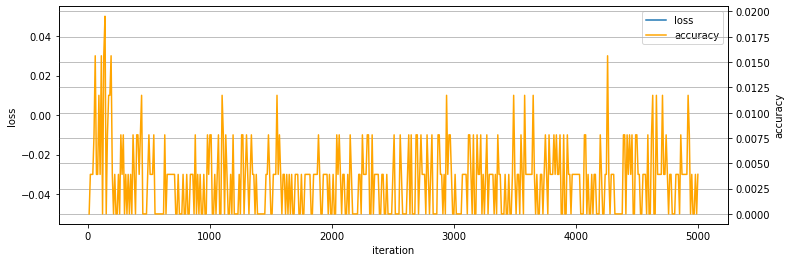

In [25]:
def plot_process():
    df = pd.read_csv(cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH)
    
    fig, ax = plt.subplots(figsize=(12, 4))
    ax2 = ax.twinx()
    lns1 = ax.plot(df['iteration'], df['loss'], label='loss')
    lns2 = ax2.plot(df['iteration'], df['accuracy'], color='orange', label='accuracy')

    lns = lns1 + lns2
    labs = [l.get_label() for l in lns]
    ax.legend(lns, labs, loc=0)
    ax.set_ylabel('loss')
    ax.set_xlabel('iteration')
    ax2.set_ylabel('accuracy')
    plt.grid()
    plt.show()

plot_process()

## Test

--------------------
test function
--------------------
--
You call EfficientNet
 - Input dim (h, w, c) >> (32, 32, 3)
--
Files already downloaded and verified
10000 / 10000
accuracy = 0.009201497192763568
ts / pred table
array([[5900.,    0.,    0., ...,    0.,    0.,    0.],
       [6100.,    0.,    0., ...,    0.,    0.,    0.],
       [5900.,    0.,    0., ...,    0.,    0.,    0.],
       ...,
       [6500.,    0.,    0., ...,    0.,    0.,    0.],
       [6900.,    0.,    0., ...,    0.,    0.,    0.],
       [7200.,    0.,    0., ...,    0.,    0.,    0.]])


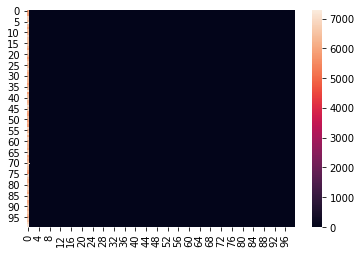

In [26]:
# test
def test():
    print('-' * 20)
    print('test function')
    print('-' * 20)
    model = EfficientNet('B0').to(cfg.DEVICE)
    model.load_state_dict(torch.load(cfg.TEST.MODEL_PATH, map_location=torch.device(cfg.DEVICE)))
    model.eval()

    np.random.seed(0)

    trainset = torchvision.datasets.CIFAR100(root=cfg.TRAIN.DATA_PATH , train=False, download=True, transform=None)
    Xs_data = np.array(trainset.data)
    ts_data = np.array(trainset.targets, dtype=int)
    data_num = len(Xs_data)
    
    table = np.zeros([cfg.CLASS_NUM, cfg.CLASS_NUM])

    inds = np.arange(data_num)

    with torch.no_grad():
        for i in range(0, data_num, cfg.TEST.MINIBATCH):
            # get batch index
            mb_inds = inds[i : min(i + cfg.TEST.MINIBATCH, data_num)]
            Xs = torch.tensor(preprocess(Xs_data[mb_inds], cfg, cfg.INPUT_MODE), dtype=torch.float).to(cfg.DEVICE)
            ts = ts_data[mb_inds]

            # forward
            ys = model(Xs).detach().cpu().numpy()
            ys = ys.argmax(axis=1)
            
            for t, y in zip(ts, ys):
                table[ts, ys] += 1

            print('\r{} / {}'.format(mb_inds[-1] + 1, data_num), end='')

    accuracy = table[np.arange(cfg.CLASS_NUM), np.arange(cfg.CLASS_NUM)].sum() / table.sum()
    print('\naccuracy =', accuracy)
    print('ts / pred table')
    pprint(table)
    sns.heatmap(table)

test()

In [27]:
def arg_parse():
    parser = argparse.ArgumentParser(description='CNN implemented with Keras')
    parser.add_argument('--train', dest='train', action='store_true')
    parser.add_argument('--test', dest='test', action='store_true')
    args = parser.parse_args()
    return args

# main
if __name__ == '__main__':
    args = arg_parse()

    if args.train:
        train()
    if args.test:
        test()

    if not (args.train or args.test):
        print("please select train or test flag")
        print("train: python main.py --train")
        print("test:  python main.py --test")
        print("both:  python main.py --train --test")


usage: ipykernel_launcher.py [-h] [--train] [--test]
ipykernel_launcher.py: error: unrecognized arguments: -f /root/.local/share/jupyter/runtime/kernel-59467a49-d530-4643-bc19-52f49a614d67.json


SystemExit: ignored

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2890: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
